In [1]:
# #安装cocoapi
# !git clone https://github.com/cocodataset/cocoapi.git
# #安装至全局，如果重启项目，这几个依赖和库需要重新安装
# %cd cocoapi/PythonAPI
# !make install
# %cd ../..   

In [2]:
import numpy as np


def trim_zeros(x):
    """It's common to have tensors larger than the available data and
    pad with zeros. This function removes rows that are all zeros.

    x: [rows, columns].
    """
    assert len(x.shape) == 2
    return x[~np.all(x == 0, axis=1)]

def compute_iou(box, boxes, box_area, boxes_area):
    """Calculates IoU of the given box with the array of the given boxes.
    box: 1D vector [x1, y1, x2, y2]
    boxes: [boxes_count, (x1, y1, x2, y2)]
    box_area: float. the area of 'box'
    boxes_area: array of length boxes_count.

    Note: the areas are passed in rather than calculated here for
    efficiency. Calculate once in the caller to avoid duplicate work.
    """
    # Calculate intersection areas
    x1 = np.maximum(box[0], boxes[:, 0])
    x2 = np.minimum(box[2], boxes[:, 2])
    y1 = np.maximum(box[1], boxes[:, 1])
    y2 = np.minimum(box[3], boxes[:, 3])
    intersection = np.maximum(x2 - x1+1, 0) * np.maximum(y2 - y1+1, 0)
    union = box_area + boxes_area[:] - intersection[:]
    iou = intersection / union
    return iou


def compute_overlaps(boxes1, boxes2):
    """Computes IoU overlaps between two sets of boxes.
    boxes1, boxes2: [N, (x1, y1, x2, y2)].

    For better performance, pass the largest set first and the smaller second.
    """
    # Areas of anchors and GT boxes
    area1 = (boxes1[:, 2] - boxes1[:, 0]+1) * (boxes1[:, 3] - boxes1[:, 1]+1)
    area2 = (boxes2[:, 2] - boxes2[:, 0]+1) * (boxes2[:, 3] - boxes2[:, 1]+1)

    # Compute overlaps to generate matrix [boxes1 count, boxes2 count]
    # Each cell contains the IoU value.
    overlaps = np.zeros((boxes1.shape[0], boxes2.shape[0]))
    for i in range(overlaps.shape[1]):
        box2 = boxes2[i]
        overlaps[:, i] = compute_iou(box2, boxes1, area2[i], area1)
    return overlaps

# 原始数据分析

- 类别不均衡，类别： {'0': 0, '1': 576, '2': 2151, '3': 2174, '4': 1112, '5': 8886, '6': 331}
- 图片像素尺寸比较大：图片平均高5562.212738017071,图片平均宽7474.7293499671705

In [3]:
#调用一些需要的第三方库
import numpy as np
import pandas as pd
import shutil
import json
import os
import cv2
import glob
from PIL import Image

In [4]:
#统计一下类别
path = "../dataset/tile_round1_train_20201231/train_annos.json"
dict_class = {
    "0":0,
    "1":0,
    "2":0,
    "3":0,
    "4":0,
    "5":0,
    "6":0
}
id_s = 0
image_width,image_height = 0,0
with open(path,"r") as f:
    files = json.load(f)
    #遍历标注文件
    for file_img in files:
        id_s += 1
        #统计类别
        file_class = file_img["category"]
        dict_class[str(file_class)] += 1
        #统计图片平均像素
        image_height += file_img["image_height"]
        image_width += file_img["image_width"]
        if id_s % 1000 is 0:
            print("处理到第{}个标注".format(id_s))
print("类别：",dict_class)
print("图片平均高{},图片平均宽{}".format(image_height/id_s,image_width/id_s))

处理到第1000个标注
处理到第2000个标注
处理到第3000个标注
处理到第4000个标注
处理到第5000个标注
处理到第6000个标注
处理到第7000个标注
处理到第8000个标注
处理到第9000个标注
处理到第10000个标注
处理到第11000个标注
处理到第12000个标注
处理到第13000个标注
处理到第14000个标注
处理到第15000个标注
类别： {'0': 0, '1': 576, '2': 2151, '3': 2174, '4': 1112, '5': 8886, '6': 331}
图片平均高5562.212738017071,图片平均宽7474.7293499671705


## 将数据标注转为coco格式
- paddledetection支持coco格式和voc格式，原数据标注不是这2种格式

In [9]:
import math
import json
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)
        
class Fabric2COCO:

    def __init__(self,
            is_mode = "train"
            ):
        self.images = []
        self.annotations = []
        self.categories = []
        self.img_id = 0
        self.ann_id = 0
        self.is_mode = is_mode
        self.patch_size = 1024
        self.stride = 512
        self.root_dir = '../dataset/coco2/{}'
        if not os.path.exists(self.root_dir.format(self.is_mode)):
            os.makedirs(self.root_dir.format(self.is_mode))

    def to_coco(self, anno_file,img_dir):
        self._init_categories()
        anno_result= pd.read_json(open(anno_file,"r"))
        name_boxes = {}
        for info in anno_result.values:
            img_name, _, _, cls, box  = info
            if img_name not in name_boxes.keys():
                name_boxes[img_name] = {'boxes':[], 'clses':[]}
            name_boxes[img_name]['boxes'].append(box)
            name_boxes[img_name]['clses'].append(cls)
        img_name_list_all = list(name_boxes.keys())
        img_name_list_all.sort()
        np.random.seed(1993)
        np.random.shuffle(img_name_list_all)
        img_num = len(img_name_list_all)
        if self.is_mode == "train":
            img_name_list = img_name_list_all[:int(img_num*0.9)]
        elif self.is_mode == "val":
            img_name_list = img_name_list_all[int(img_num*0.9):]

        for img_name in img_name_list:
            img_prefix = os.path.splitext(img_name)[0]
            boxes = np.array(name_boxes[img_name]['boxes'])
            defect_names = np.array(name_boxes[img_name]['clses'])

            img_path=os.path.join(img_dir,img_name)
            img =cv2.imread(img_path)
            h, w, _= img.shape

            new_img_h = math.ceil(h/self.patch_size)*self.patch_size
            new_img_w = math.ceil(w/self.patch_size)*self.patch_size
            new_img = np.zeros([new_img_h, new_img_w, 3])
            new_img[:h, :w, :] = img

            for i in range(0, new_img_w-self.patch_size, self.stride):
                for j in range(0, new_img_h-self.patch_size, self.stride):
                    img_patch = new_img[j:j+self.patch_size, i:i+self.patch_size, :]
                    iou = compute_overlaps(np.array([[i,j, i+self.patch_size, j+self.patch_size]]), boxes)
                    iou = iou.reshape(-1)
                    index = iou > 0
                    if np.sum(index) == 0: 
                        self._clean_img(img_prefix+'-{:0>2}_{:0>2}.jpg'.format(i, j), img_patch)#复制文件路径
                        continue
                    boxes_temp = boxes[index]
                    clses_temp = defect_names[index]
                    boxes_temp[:, 0] = boxes_temp[:, 0] - i
                    boxes_temp[:, 1] = boxes_temp[:, 1] - j
                    boxes_temp[:, 2] = boxes_temp[:, 2] - i
                    boxes_temp[:, 3] = boxes_temp[:, 3] - j
                    path_temp = os.path.join(img_dir)
                    self.images.append(self._image(img_prefix+'-{:0>6}_{:0>2}_{:0>2}.jpg'.format(self.img_id, i, j),1024, 1024))

                    self._cp_img(img_prefix+'-{:0>6}_{:0>2}_{:0>2}.jpg'.format(self.img_id, i, j), img_patch)#复制文件路径
                    
                    if self.img_id % 400 is 0:
                        print("处理到第{}张图片".format(self.img_id))
                    for bbox, label in zip(boxes_temp, clses_temp):
                        annotation = self._annotation(label, bbox)
                        self.annotations.append(annotation)
                        self.ann_id += 1
                    self.img_id += 1
        instance = {}
        instance['info'] = 'fabric defect'
        instance['license'] = ['Yuan']
        instance['images'] = self.images
        instance['annotations'] = self.annotations
        instance['categories'] = self.categories
        return instance

    def _init_categories(self):
        #1，2，3，4，5，6个类别
        for v in range(1,7):
            print(v)
            category = {}
            category['id'] = v
            category['name'] = str(v)
            category['supercategory'] = 'defect_name'
            self.categories.append(category)

    def _image(self, path,h,w):
        image = {}
        image['height'] = h
        image['width'] = w
        image['id'] = self.img_id
        image['file_name'] = os.path.basename(path)#返回path最后的文件名
        return image

    def _annotation(self,label,bbox):
        bbox[0] = min(max(bbox[0], 0), self.patch_size-1)
        bbox[1] = min(max(bbox[1], 0), self.patch_size-1)
        bbox[2] = min(max(bbox[2], 0), self.patch_size-1)
        bbox[3] = min(max(bbox[3], 0), self.patch_size-1)
        area=(bbox[2]-bbox[0])*(bbox[3]-bbox[1])
        points=[[bbox[0],bbox[1]],[bbox[2],bbox[1]],[bbox[2],bbox[3]],[bbox[0],bbox[3]]]
        annotation = {}
        annotation['id'] = self.ann_id
        annotation['image_id'] = self.img_id
        annotation['category_id'] = label
        annotation['segmentation'] = []# np.asarray(points).flatten().tolist()
        annotation['bbox'] = self._get_box(points)
        annotation['iscrowd'] = 0
        annotation["ignore"] = 0
        annotation['area'] = area
        return annotation

    def _cp_img(self, img_name, img_patch):
        cv2.imwrite(os.path.join(self.root_dir.format(self.is_mode), img_name), img_patch)
#         shutil.copy(img_path, os.path.join(self.root_dir.format(self.is_mode), os.path.basename(img_path)))
    def _clean_img(self, img_name, img_patch):
        if not os.path.exists(os.path.join(self.root_dir.format(self.is_mode+'_clean'))):
            os.makedirs(os.path.join(self.root_dir.format(self.is_mode+'_clean')))
        cv2.imwrite(os.path.join(self.root_dir.format(self.is_mode+'_clean'), img_name), img_patch)
#         shutil.copy(img_path, os.path.join(self.root_dir.format(self.is_mode), os.path.basename(img_path)))
    def _get_box(self, points):
        min_x = min_y = np.inf
        max_x = max_y = 0
        for x, y in points:
            min_x = min(min_x, x)
            min_y = min(min_y, y)
            max_x = max(max_x, x)
            max_y = max(max_y, y)
        '''coco,[x,y,w,h]'''
        return [min_x, min_y, max_x - min_x, max_y - min_y]
    def save_coco_json(self, instance, save_path):
        import json
        with open(save_path, 'w') as fp:
            json.dump(instance, fp, indent=1, separators=(',', ': '), cls=NpEncoder)#缩进设置为1，元素之间用逗号隔开 ， key和内容之间 用冒号隔开
    
    def split_test(self, test_dir='../dataset/coco/tile_round1_testA_20201231/testA_imgs/'):
        img_name_list = os.listdir(test_dir)
        img_name_list.sort()
        for img_name in tqdm_notebook(img_name_list):
            img_prefix = os.path.splitext(img_name)[0]

            img_path=os.path.join(test_dir, img_name)
            img =cv2.imread(img_path)
            h, w, _= img.shape

            new_img_h = math.ceil(h/self.patch_size)*self.patch_size
            new_img_w = math.ceil(w/self.patch_size)*self.patch_size
            new_img = np.zeros([new_img_h, new_img_w, 3])
            new_img[:h, :w, :] = img

            for i in range(0, new_img_w-self.patch_size, self.stride):
                for j in range(0, new_img_h-self.patch_size, self.stride):
                    img_patch = new_img[j:j+self.patch_size, i:i+self.patch_size, :]
                   
                    self._clean_img(img_prefix+'-{:0>2}_{:0>2}.jpg'.format(i, j), img_patch)#复制文件路径
                  

In [39]:
'''转换有瑕疵的样本为coco格式'''
#训练集,划分90%做为训练集，处理需要50分钟
img_dir = "../dataset/tile_round1_train_20201231/train_imgs"
anno_dir="../dataset/tile_round1_train_20201231/train_annos.json"
fabric2coco = Fabric2COCO()
train_instance = fabric2coco.to_coco(anno_dir,img_dir)
if not os.path.exists("../dataset/coco2/annotations/"):
    os.makedirs("../dataset/coco2/annotations/")
fabric2coco.save_coco_json(train_instance, "../dataset/coco2/annotations/"+'instances_{}.json'.format("train"))

1
2
3
4
5
6
处理到第0张图片
处理到第400张图片
处理到第800张图片
处理到第1200张图片
处理到第1600张图片
处理到第2000张图片
处理到第2400张图片
处理到第2800张图片
处理到第3200张图片
处理到第3600张图片
处理到第4000张图片
处理到第4400张图片
处理到第4800张图片
处理到第5200张图片
处理到第5600张图片
处理到第6000张图片
处理到第6400张图片
处理到第6800张图片
处理到第7200张图片
处理到第7600张图片
处理到第8000张图片
处理到第8400张图片
处理到第8800张图片
处理到第9200张图片
处理到第9600张图片
处理到第10000张图片
处理到第10400张图片
处理到第10800张图片
处理到第11200张图片
处理到第11600张图片
处理到第12000张图片
处理到第12400张图片
处理到第12800张图片
处理到第13200张图片
处理到第13600张图片
处理到第14000张图片
处理到第14400张图片
处理到第14800张图片
处理到第15200张图片
处理到第15600张图片
处理到第16000张图片
处理到第16400张图片
处理到第16800张图片
处理到第17200张图片
处理到第17600张图片
处理到第18000张图片
处理到第18400张图片
处理到第18800张图片
处理到第19200张图片
处理到第19600张图片
处理到第20000张图片
处理到第20400张图片
处理到第20800张图片
处理到第21200张图片
处理到第21600张图片
处理到第22000张图片
处理到第22400张图片
处理到第22800张图片
处理到第23200张图片
处理到第23600张图片
处理到第24000张图片
处理到第24400张图片
处理到第24800张图片
处理到第25200张图片
处理到第25600张图片
处理到第26000张图片
处理到第26400张图片
处理到第26800张图片
处理到第27200张图片
处理到第27600张图片
处理到第28000张图片
处理到第28400张图片
处理到第28800张图片
处理到第29200张图片
处理到第29600张图片
处理到第30000张图片
处理到第30400张图片
处理到第30800张图片
处理到第

In [40]:
'''转换有瑕疵的样本为coco格式'''
#验证集，划分10%做为验证集
img_dir = "../dataset/tile_round1_train_20201231/train_imgs"
anno_dir="../dataset/tile_round1_train_20201231/train_annos.json"
fabric2coco = Fabric2COCO(is_mode = "val")
train_instance = fabric2coco.to_coco(anno_dir,img_dir)
if not os.path.exists("../dataset/coco2/annotations/"):
    os.makedirs("../dataset/coco2/annotations/")
fabric2coco.save_coco_json(train_instance, "../dataset/coco2/annotations/"+'instances_{}.json'.format("val"))

1
2
3
4
5
6
处理到第0张图片
处理到第400张图片
处理到第800张图片
处理到第1200张图片
处理到第1600张图片
处理到第2000张图片
处理到第2400张图片
处理到第2800张图片
处理到第3200张图片
处理到第3600张图片
处理到第4000张图片


In [10]:
# inference split
test_dir = '../dataset/coco/tile_round1_testA_20201231/testA_imgs/'

fabric2coco = Fabric2COCO(is_mode = "test")
fabric2coco.split_test(test_dir)

/home/psdz/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:162: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


## 载入标注JSON文件

In [11]:
import json
with open('../dataset/coco2/annotations/instances_train.json') as f:
    a=json.load(f)

In [12]:
co=0
for c in a['annotations']:
    if c['image_id']==2:
        co+=1
co

1

## 查看类别标签

In [13]:
print('标签类别:')
print('类别数量：',len(a['categories']))
a['categories']
num_imgs = len(a['images'])

print('训练集图片数量：',len(a['images']))
print('训练集标签数量：',len(a['annotations']))

标签类别:
类别数量： 6
训练集图片数量： 38209
训练集标签数量： 50192


## 查看图像尺寸

In [14]:
total=[]
for img in a['images']:
    hw=(img['height'],img['width'])
    total.append(hw)
unique=set(total)
for k in unique:
    print('长宽为(%d,%d)的图片数量为：'%k,total.count(k))

长宽为(1024,1024)的图片数量为： 38209


## 查看id 情况

In [15]:
ids=[]
images_id=[]
for i in a['annotations']:
    ids.append(i['id'])
    images_id.append(i['image_id'])
print('训练集图片数量:',num_imgs)
print('unique id 数量：',len(set(ids)))
print('unique image_id 数量',len(set(images_id)))
## 可以看出image_id和图片是一一对应的 ,annotation里面的id存在除非，没有实际意义

训练集图片数量: 38209
unique id 数量： 50192
unique image_id 数量 38209


## 查看统计量

In [16]:
import pandas as pd
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['font.family']='sans-serif'
plt.rcParams['figure.figsize'] = (10.0, 10.0)

In [17]:
##创建类别标签字典
category_dic=dict([(i['id'],i['name']) for i in a['categories']])
print(category_dic)
counts_label=dict([(i['name'],0) for i in a['categories']])

for i in a['annotations']:
    counts_label[category_dic[i['category_id']]]+=1
print('')
print('数量统计', counts_label)

for key in counts_label.keys():
    counts_label[key] += 1

{1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6'}

数量统计 {'1': 1891, '2': 5033, '3': 7679, '4': 3988, '5': 30415, '6': 1186}


/home/psdz/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  """
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


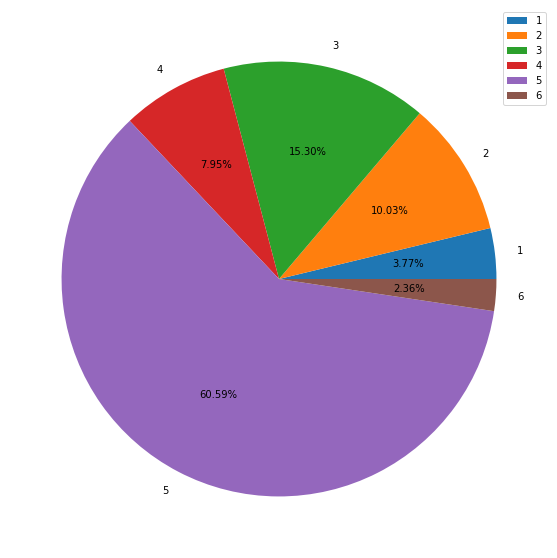

In [18]:
plt.figure(figsize=(10,10))
indexs=counts_label.keys()
values=counts_label.values()
Count_df=pd.DataFrame(list(values),index=indexs)
plt.pie(Count_df, labels=indexs, autopct='%1.2f%%')
plt.legend()
plt.show()

## 各标签直方图

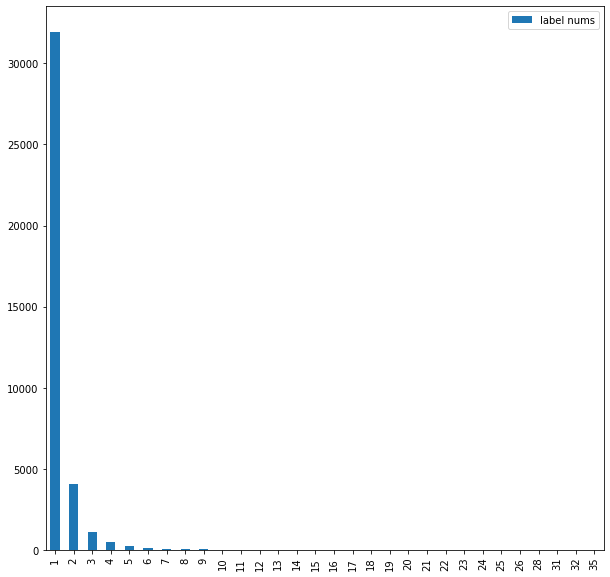

In [19]:
annoto_count={}
for i in a['annotations']:
    annoto_count[i['image_id']]=annoto_count.setdefault(i['image_id'],0)+1
indes_list=set(annoto_count.values())
values_count=[list(annoto_count.values()).count(i) for i in indes_list]
pd.DataFrame(values_count,index=indes_list,columns=['label nums']).plot(kind='bar')
plt.show()

## 图像和标签对应起来

In [20]:
data=[]
per_sample={}
anntotations=[]
for i in a['annotations']:
    an=i
    an.pop('id')
    an.pop('iscrowd')
    anntotations.append(an)

for img in a['images']:
    sample_img=img
    annota_list=[]# 保存该图片对应的标签
    for per in anntotations:
        if per['image_id']==img['id'] and per['category_id']!=0: #0背景不预测
            annota_list.append(per)
    for k in annota_list:
        anntotations.remove(k)
    sample_img['annotations']=annota_list
    data.append(sample_img)

## 标注长宽统计

[0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 256, 272, 288, 304, 320, 336, 352, 368, 384, 400, 416, 432, 448, 464, 480, 496, 512, 528, 544, 560, 576, 592, 608, 624, 640, 656, 672, 688, 704, 720, 736, 752, 768, 784, 800, 816, 832, 848, 864, 880]


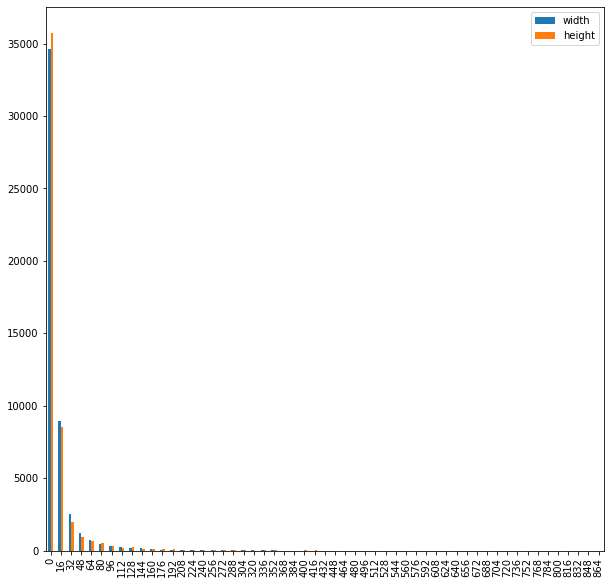

In [21]:
total_width=[]
total_height=[]

width=max([data[i]['width'] for i in range(len(data))])
height=max([data[i]['height'] for i in range(len(data))])
maxrange=max(width,height)
for im in data:
    for b in im['annotations']:
        total_width+=[b['bbox'][2]]
        total_height+=[b['bbox'][3]]
gap= 16
group_names = [i for i in range(0,896,gap)]
print(group_names)
width_cuts = pd.cut(total_width,bins=group_names,labels=group_names[:-1]) # ,labels=group_names
height_cuts = pd.cut(total_height,bins=group_names,labels=group_names[:-1]) # ,labels=group_names

total_df=pd.DataFrame({'width':width_cuts.value_counts(),'height':height_cuts.value_counts()})
total_df.plot(kind='bar')

In [ ]:
width_cuts.value_counts()

## coco vis

In [22]:
# %matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab

In [23]:

image_directory = '../dataset/coco2/train'
annotation_file = '../dataset/coco2/annotations/instances_train.json'

In [24]:
example_coco = COCO(annotation_file)

categories = example_coco.loadCats(example_coco.getCatIds())
category_names = [category['name'] for category in categories]
print('Custom COCO categories: \n{}\n'.format(' '.join(category_names)))

category_ids = example_coco.getCatIds(catNms=['5'])
image_ids = example_coco.getImgIds(catIds=category_ids)
image_data = example_coco.loadImgs(image_ids[np.random.randint(0, len(image_ids))])[0]

loading annotations into memory...
Done (t=0.23s)
creating index...
index created!
Custom COCO categories: 
1 2 3 4 5 6



In [25]:
for i in range(len(image_ids)):
    image_data = example_coco.loadImgs(image_ids[i])[0]
    break

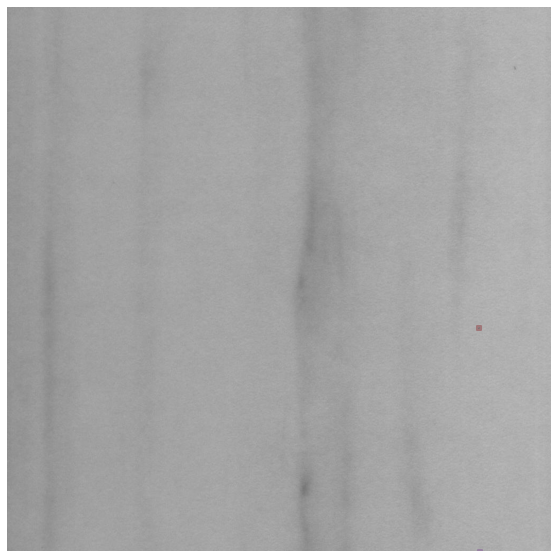

In [26]:
import os
# load and display instance annotations
image = io.imread(os.path.join(image_directory, image_data['file_name']))
plt.imshow(image); plt.axis('off')
pylab.rcParams['figure.figsize'] = (10, 10)
annotation_ids = example_coco.getAnnIds(imgIds=image_data['id'], catIds=category_ids, iscrowd=None)
annotations = example_coco.loadAnns(annotation_ids)
example_coco.showAnns(annotations, draw_bbox=True)